# 📊 Multi-Config Metrics Evaluation
Questo notebook analizza tutte le configurazioni (`top1`, `top10`, `top10_wot`) per entrambi i dataset (`geolife`, `fsq`).

In [21]:

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import json
import logging
from sklearn.metrics import f1_score
from pathlib import Path

# Logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("multi_metrics")

# Funzione per parse sicuro della predizione
def safe_parse_prediction(x):
    try:
        if isinstance(x, str):
            return ast.literal_eval(x)
        elif isinstance(x, list):
            return x
        else:
            return []
    except Exception as e:
        logger.warning(f"⚠️ Parsing fallito per predizione: {x} con errore: {e}")
        return []

# Funzione per analizzare una singola configurazione
def analyze_config(path):
    logger.info(f"📂 Analisi cartella: {path}")
    
    if not os.path.exists(path):
        logger.warning(f"🚫 Cartella non trovata: {path}\n\n")
        return  # Skippa questa configurazione
    
    file_list = sorted([f for f in os.listdir(path) if f.endswith(".csv")])
    df = pd.DataFrame()
    
    for file in file_list:
        file_path = os.path.join(path, file)
        try:
            #logger.info(f"Leggo: {file_path}")
            temp_df = pd.read_csv(file_path)
            df = pd.concat([df, temp_df], ignore_index=True)
        except Exception as e:
            logger.warning(f"❌ Errore lettura {file_path}: {e}")
    # 🧹 Pulizia ground_truth: assicura che sia int e scarta righe non valide
    def safe_cast_gt(val):
        try:
            return int(val)
        except:
            logger.warning(f"⚠️ Valore non numerico ignorato in ground_truth: {val}")
            return None

    df['ground_truth'] = df['ground_truth'].apply(safe_cast_gt)
    df = df.dropna(subset=['ground_truth'])  # Rimuove righe con ground_truth non validi

    if df.empty:
        logger.warning(f"Nessun dato trovato in {path}")
        return None

    # Parsing e metrica
    df['prediction'] = df['prediction'].apply(safe_parse_prediction)
    df['hit@10'] = df.apply(
    lambda row: row['ground_truth'] in row['prediction'] if isinstance(row['prediction'], list) else False,
    axis=1
    )
    acc_at_10 = df['hit@10'].mean()

    # Predizione principale per F1
    majority_preds = [row[0] if isinstance(row, list) and row else -1 for row in df['prediction']]
    try:
        df['ground_truth'] = df['ground_truth'].astype(int)
        majority_preds = [int(p) for p in majority_preds]
        f1 = f1_score(df['ground_truth'], majority_preds, average='macro')
    except Exception as e:
        logger.warning(f"⚠️ Errore F1 Score: {e}")
        f1 = 0.0

    # Grafico
    plt.figure(figsize=(6, 4))
    sns.barplot(x=['Acc@10', 'F1'], y=[acc_at_10, f1])
    plt.title(f"Metriche - {path}")
    plt.ylim(0, 1)
    plt.show()
    
    print(f"✅ Acc@10: {round(acc_at_10, 4)}")
    print(f"✅ F1 Score: {round(f1, 4)}")
    return df


INFO:multi_metrics:📂 Analisi cartella: output/geolife/top1


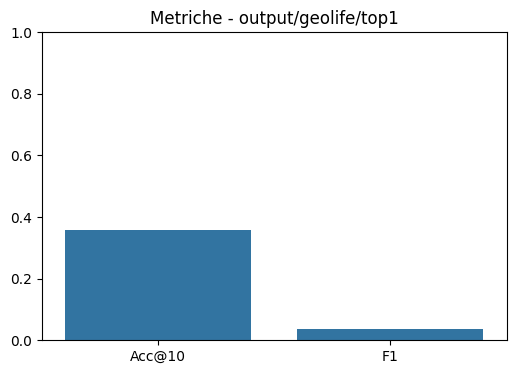

INFO:multi_metrics:📂 Analisi cartella: output/geolife/top10


✅ Acc@10: 0.3585
✅ F1 Score: 0.0379



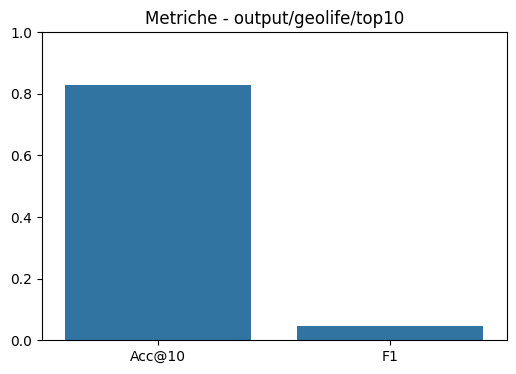

INFO:multi_metrics:📂 Analisi cartella: output/geolife/top10_wot


✅ Acc@10: 0.8291
✅ F1 Score: 0.0467



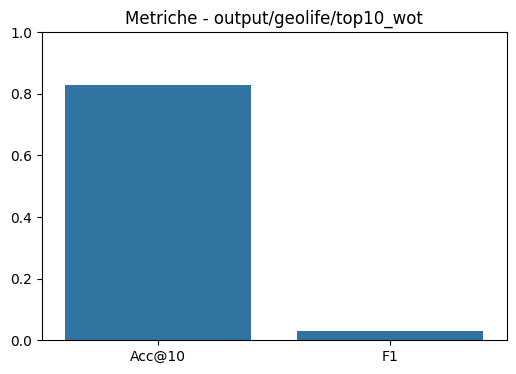

INFO:multi_metrics:📂 Analisi cartella: output/fsq/top1


✅ Acc@10: 0.828
✅ F1 Score: 0.0317



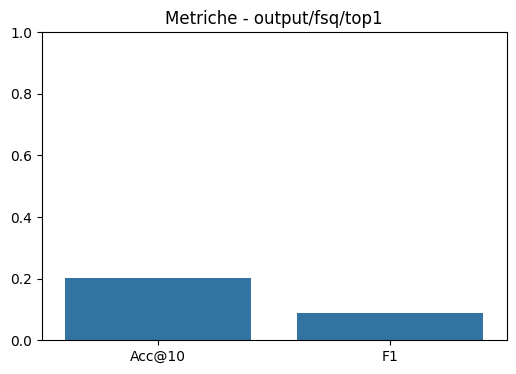

INFO:multi_metrics:📂 Analisi cartella: output/fsq/top10


✅ Acc@10: 0.2035
✅ F1 Score: 0.0896



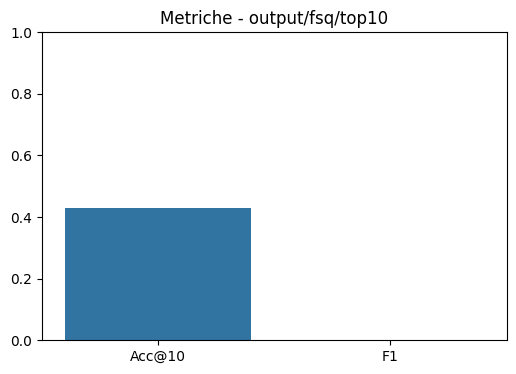

INFO:multi_metrics:📂 Analisi cartella: output/fsq/top10_wot


✅ Acc@10: 0.4291
✅ F1 Score: 0.0



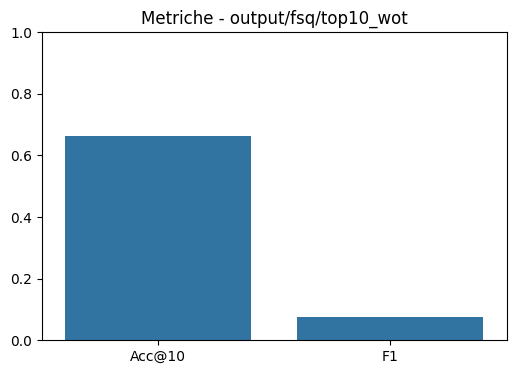

✅ Acc@10: 0.6633
✅ F1 Score: 0.0757


In [22]:

# 📁 Percorsi da analizzare
configs = [
    "output/geolife/top1",
    "output/geolife/top10",
    "output/geolife/top10_wot",
    "output/fsq/top1",
    "output/fsq/top10",
    "output/fsq/top10_wot",
]

# 🚀 Avvia analisi
for path in configs:
    print("\n" + "="*60)
    analyze_config(path)
